# Clasificación de textos con aprendizaje automático

El objetivo de este notebook es mostrar cómo clasificar textos con algoritmos clásicos de aprendizaje automático. 

*Este notebook reutiliza y modifica el notebook preparado por el profesor Antonio Alejandro Sánchez Ruiz-Granados, que a su vez modifica el preparado [por NLP Town](http://www.nlp.town) y [disponible en github](https://github.com/nlptown/nlp-notebooks/blob/master/Traditional%20text%20classification%20with%20Scikit-learn.ipynb).*



## Conjunto de datos

El conjunto de datos será el de [20 Newsgroups](http://qwone.com/~jason/20Newsgroups/), que es usado a menudo como benchmark para modelos de clasificación de textos y que se encuentra disponible en [Scikit-learn](https://scikit-learn.org/stable/). 

El conjunto consiste en textos sobre diferentes temas, desde hardware hasta religión. Algunos temas están muy relacionados, p.ej. "IBM PC hardware" y "Mac hardware", mientras que otros son más diversos, p.ej. "religion" o "hockey"). 

Está dividido de forma predeterminada en entrenamiento y validación en porcentajes de 60 y 40, respectivamente. 

In [1]:
from sklearn.datasets import fetch_20newsgroups

In [2]:
train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test')

print("Training texts:", len(train_data.data))
print("Test texts:", len(test_data.data))

Training texts: 11314
Test texts: 7532


## Preprocesado de datos

Para que un clasificador de aprendizaje automático pueda trabajar debemos transformar cada texto a un vector de variables descriptivas y, por tanto, el conjunto de textos pasará a ser una matriz de datos donde por columnas tengamos las variables de entrada y por filas cada uno de los textos del conjunto. Además habrá una columna indicando la clase del texto, es decir, el tema del grupo de noticias al que pertenece el texto.

Seguiremos la aproximación de la "bolsa-de-palabras". Cada texto, será transformado en un vector de palabras (o n-gramas) con su frecuencia de aparición en el texto. El orden de aparición dejar de ser relevante. Las palabras que no aparecen en dicho texto, pero sí en otros del conjunto de datos, tendrán frecuencia cero.

En Scikit-learn, podemos construir esa matriz de datos con `CountVectorizer`, que transforma el texto en variables, donde cada variable es una palabra, y cuenta las veces que aparece dicha palabra en el corpus de documentos. Si no le facilitamos un diccionario (en nuestro caso no lo hará), las variables que extraerá serán aquellas palabras encontradas analizando el corpus. 

Sin embargo, esas cuentas no son excesivamente útiles ya que contendrá palabras que son muy frecuentes en inglés, como  *a*, *the* o *be*. Estas palabras no tienen un gran poder discriminante, como si lo tendrían en este caso palabras como  *computer* o *hardware*: palabras que son frecuentes en textos de una clase, pero no de otras.  Para ello es necesario utilizar un peso según su TF-IDF, lo cual será más útil que la frecuencia en bruto en contextos de recuperación de información o clasificación. El TF-IDF cuenta el número de veces que una palabra aparece en un texto, divido entre el logaritmo del porcentaje de documentos del corpus que contienen dicho término. Para ello generar estos pesos utilizaremos el `TfidfTransformer` de Scikit-learn.



### Diferenciando entre entrenamiento y validación

En primer lugar aplicaremos las transformaciones en el conjunto de entrenamiento. Observa que tanto el diccionario usado, como la frecuencia inversa de aparición de un término en los documentos (es decir, el término IDF), debe ser el mismo en los conjuntos de entrenamiento y de test. Por ello, observa que usamos `fit_transform` para el conjunto de entrenamiento,  para fijar el dicccionario en `CountVectorizer` y el término idf del `TfidfTransformer`, mientras que usamos `transform` en el conjunto de test (de forma que ambas herramientas usan lo aprendido en el conjunto de entrenamiento)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer(stop_words = 'english', ngram_range = (1,2))
tfidfer= TfidfTransformer()

# Tomamos los textos del conjunto de entrenamiento y los transformamos en 
# una matriz de datos (palabras) según el diccionario estándar
train_vector_data=vectorizer.fit_transform(train_data.data)
# Calculamos el valor TF-IDF 
train_preprocessed=tfidfer.fit_transform(train_vector_data)

# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data=vectorizer.transform(test_data.data)
# Calculamos el valor TF-IDF 
# Al usar "transform" toma como IDF el del conjunto de entrenamiento 
test_preprocessed=tfidfer.transform(test_vector_data)


## Entrenando los modelos de aprendizaje automático

Vamos a probar los clasificadores que ya conocemos en el problema de clasificación de textos.

La versión que vamos a usar de los clasificadores es la versión por defecto. Sin embargo, es posible encontrar mejores clasificadores buscando combinaciones de parámetros más adecuadas durante el aprendizaje. Puedes usar la búsqueda en rejilla para ello (grid search) probando distintos valores de parámetros o combinaciones de ellos.

### Árbol de decisión 

In [86]:
from sklearn import tree
import numpy as np

values = [x for x in range(2,10)]
train_ = []
test_ = []

# Creamos el clasificador con los valores por defecto
for i in range (2,10):
    tree_classifier = tree.DecisionTreeClassifier(min_samples_split = i, random_state = 0)
    tree_classifier.fit(train_preprocessed, train_data.target)

    tree_train_predictions = tree_classifier.predict(train_preprocessed)
    tree_test_predictions = tree_classifier.predict(test_preprocessed)

    train_.append(np.mean(tree_train_predictions == train_data.target))
    test_.append(np.mean(tree_test_predictions == test_data.target))

In [ ]:
import matplotlib.pyplot as plt
from math import log

#plt.plot(values, train_, label="Entrenamiento", color = "gold")
plt.plot(values, test_, label="Test", color = "plum")

# Create plot
plt.title("Comparativa del número mínimo de muestras por hoja")
plt.xlabel("Número mínimo de muestras por hoja"), plt.ylabel("Precisión"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [97]:
values = [i for i in range (60,220,40)]
train_ = []
test_ = []

for i in range (60,220,40):
    tree_classifier = tree.DecisionTreeClassifier(max_depth =  i, random_state = 0)
    tree_classifier.fit(train_preprocessed, train_data.target)

    tree_train_predictions = tree_classifier.predict(train_preprocessed)
    tree_test_predictions = tree_classifier.predict(test_preprocessed)

    train_.append(np.mean(tree_train_predictions == train_data.target))
    test_.append(np.mean(tree_test_predictions == test_data.target))

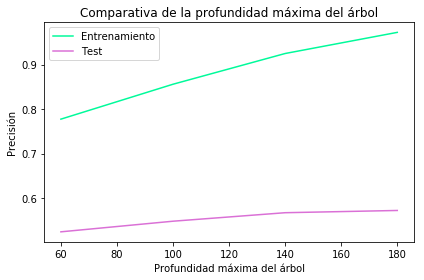

In [101]:
import matplotlib.pyplot as plt
from math import log

plt.plot(values, train_, label="Entrenamiento", color = "mediumspringgreen")
plt.plot(values, test_, label="Test", color = "orchid")

# Create plot
plt.title("Comparativa de la profundidad máxima del árbol")
plt.xlabel("Profundidad máxima del árbol"), plt.ylabel("Precisión"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [108]:
criterios = ['entropy', 'gini']
train_ = []
test_ = []
for i in criterios:
    tree_classifier = tree.DecisionTreeClassifier(criterion = i, random_state = 0)
    tree_classifier.fit(train_preprocessed, train_data.target)

    tree_train_predictions = tree_classifier.predict(train_preprocessed)
    tree_test_predictions = tree_classifier.predict(test_preprocessed)

    train_.append(np.mean(tree_train_predictions == train_data.target))
    test_.append(np.mean(tree_test_predictions == test_data.target))

[0.9999116139296447, 0.9999116139296447]


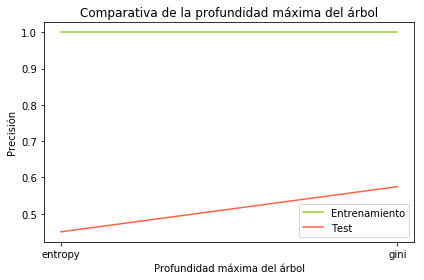

In [109]:
import matplotlib.pyplot as plt
from math import log

print(train_)

plt.plot(criterios, train_, label="Entrenamiento", color = "yellowgreen")
plt.plot(criterios, test_, label="Test", color = "tomato")

# Create plot
plt.title("Comparativa de la profundidad máxima del árbol")
plt.xlabel("Profundidad máxima del árbol"), plt.ylabel("Precisión"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Podemos ver un fuerte sobre-aprendizaje, por lo que es conveniente mejorar el árbol modificando los parámetros de entrenamiento para que aumente la capacidad de generalización del árbol.

### k Vecinos Más Cercanos (k-NN)

In [5]:
from sklearn import neighbors

knn_classifier = neighbors.KNeighborsClassifier()
knn_classifier.fit(train_preprocessed, train_data.target)

knn_train_predictions = knn_classifier.predict(train_preprocessed)
knn_test_predictions = knn_classifier.predict(test_preprocessed)

print("k-NN, porcentaje de aciertos en entrenamiento:", np.mean(knn_train_predictions == train_data.target))
print("k-NN, porcentaje de aciertos en test:", np.mean(knn_test_predictions == test_data.target))

k-NN, porcentaje de aciertos en entrenamiento: 0.8789994696835779
k-NN, porcentaje de aciertos en test: 0.6591874668082847


Según los resultados es posible que se pueda encontrar parámetros para el que la diferencia entre el error de entrenamiento y test no sea tan acusada.

No obstante, el k-NN no es una técnica adecuada para este tipo de problemas donde las variables son del orden de los millares (palabras diferentes en el corpus) ya que sufre de la maldición de la dimensionalidad. Intenta buscar vecinos en un espacio de dimensiones muy elevado y además muy escasamente poblado (sparsity). En este caso el problema es muy significativo ya que el número de instancias de entrenamiento (11.314) es incluso menor que el número de dimensiones que se usa para representarlas (130.107).

### Naive Bayes

El clasificador [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) es un clasificador probabilístico muy simple y muy poderoso en este (y otros) contextos. 

El clasificador se llama "naive" es decir "ingenuo" porque asume que todas las variables son independientes entre sí. En este caso, que la ocurrencia de una palabra en un texto es independiente del resto de palabras. Esto no es así (en un texto de hardware es probable encontrar palabras como "CPU" y "motherboard", mientras que en uno de religión encontraremos "pray" y "God"). Pese a esta gran simplificación de la realidad el clasificador funciona muy bien.

El clasificador aprende cómo de frecuente es cada clase y cómo de frecuente es que una palabra ocurra en cada clase. A la hora de clasificar un texto nuevo, el clasificador estima la probabilidad de que pertenca a cada una de las clases y elige la más alta. Para estimar la probabilidad lo que hace es multiplicar las probabilidades de cada palabra $x_i$ dada cada clase  $C$. 

\begin{equation*}
\hat y = argmax_k\  p(C_k) \prod_{i=1}^n p(x_i \mid C_k)
\end{equation*}

Los clasificadores Naive Bayes Classifiers se entrenan muy rápido, pero no son los mejores. Suelen ser utilizados como clasificadores de referencia.


Existen tres tipos de Naive Bayes que se suelen utilizar en PLN según el tipo de problema:
 - Naive Bayes Multinomial que se utiliza cuando la frecuencia de las palabras es relevante a la hora de la clasificación, como es el caso que estamos viendo de clasificación de textos según el tema. 
 - Naive Bayes Multinomial Binarizado que se utiliza cuando lo importante es la aparición de las palabras (o de determinadas palabras), no así su frecuencia. Es el caso de los problemas de análisis de sentimiento (sentiment analysis) de un texto, donde lo que importa es la presencia de palabras que indiquen un sentimiento positivo o negativo, no su frecuencia.  
 - Naive Bayes Bernouilli que se utiliza cuando es la ausencia de determinadas palabras la que importa. Por tanto, suele ser adecuado para clasificar documentos cortos (menos variedad de palabras) y para identificar contenido muy específico como SPAM y contenido adulto. 

In [120]:
from sklearn.naive_bayes import MultinomialNB

probab = ['Multinomial', 'Bernouilli']
train_ = []
test_ = []
nb_classifier = MultinomialNB()

nb_classifier.fit(train_preprocessed, train_data.target)

nb_train_predictions = nb_classifier.predict(train_preprocessed)
nb_test_predictions = nb_classifier.predict(test_preprocessed)

train_.append(np.mean(nb_train_predictions == train_data.target))
test_.append(np.mean(nb_test_predictions == test_data.target))

In [121]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
nb_classifier = BernoulliNB()

nb_classifier.fit(train_preprocessed, train_data.target)

nb_train_predictions = nb_classifier.predict(train_preprocessed)
nb_test_predictions = nb_classifier.predict(test_preprocessed)


train_.append(np.mean(nb_train_predictions == train_data.target))
test_.append(np.mean(nb_test_predictions == test_data.target))

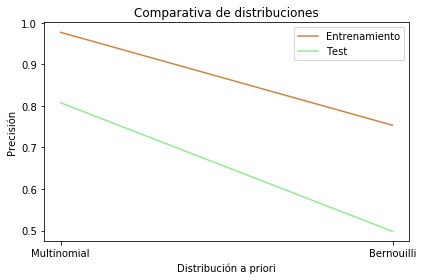

In [126]:
import matplotlib.pyplot as plt
from math import log


# Draw lines
plt.plot(probab, train_, label="Entrenamiento", color = "peru")
plt.plot(probab, test_, label="Test", color = "lightgreen")

# Create plot
plt.title("Comparativa de distribuciones")
plt.xlabel("Distribución a priori"), plt.ylabel("Precisión"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [123]:
from sklearn.naive_bayes import MultinomialNB

train_data_predictions_gr1 = []
test_data_predictions_gr1 = []
alphas = []
x = 5
while(x >= 0.000001):
    
    alphas.append(x)
    
    nb_classifier = MultinomialNB(alpha = x)
    nb_classifier.fit(train_preprocessed, train_data.target)

    nb_train_predictions = nb_classifier.predict(train_preprocessed)
    nb_test_predictions = nb_classifier.predict(test_preprocessed)

    train_data_predictions_gr1.append(np.mean(nb_train_predictions == train_data.target))
    test_data_predictions_gr1.append(np.mean(nb_test_predictions == test_data.target))
    
    
    x = x/2
beta = alphas.copy()

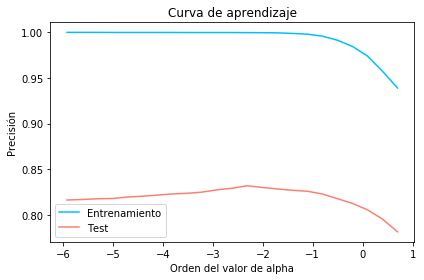

In [60]:
import matplotlib.pyplot as plt
from math import log

alphas = [log(x,10) for x in beta]

# Draw lines
plt.plot(alphas, train_data_predictions_gr1, label="Entrenamiento", color = "deepskyblue")
plt.plot(alphas, test_data_predictions_gr1, label="Test", color = "salmon")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Orden del valor de alpha"), plt.ylabel("Precisión"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [127]:
from sklearn.naive_bayes import MultinomialNB

train_data_predictions_gr1 = []
test_data_predictions_gr1 = []
alphas = []
x = 0.01
while(x >= 0.001):
    
    alphas.append(x)
    
    nb_classifier = MultinomialNB(alpha = x)
    nb_classifier.fit(train_preprocessed, train_data.target)

    nb_train_predictions = nb_classifier.predict(train_preprocessed)
    nb_test_predictions = nb_classifier.predict(test_preprocessed)

    train_data_predictions_gr1.append(np.mean(nb_train_predictions == train_data.target))
    test_data_predictions_gr1.append(np.mean(nb_test_predictions == test_data.target))
    
    
    
    x = x-0.0005
beta = alphas.copy()

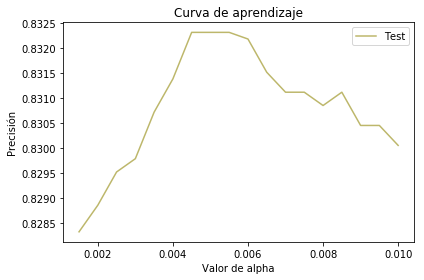

In [128]:
import matplotlib.pyplot as plt
from math import log

alphas = [x for x in beta]

# Draw lines
plt.plot(alphas, test_data_predictions_gr1, label="Test", color = "darkkhaki")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Valor de alpha"), plt.ylabel("Precisión"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

No pintamos la segunda porque no se percibe bien donde está el pico

In [112]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB(alpha = 0.005)
nb_classifier.fit(train_preprocessed, train_data.target)
nb_train_predictions = nb_classifier.predict(train_preprocessed)
nb_test_predictions = nb_classifier.predict(test_preprocessed)
    
print("Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(nb_train_predictions == train_data.target))
print("Naive Bayes, porcentaje de aciertos en test:", np.mean(nb_test_predictions == test_data.target))

Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9993812975075128
Naive Bayes, porcentaje de aciertos en test: 0.8323154540626659


### Perceptrón multicapa

El perceptrón multicapa es también un clasificador adecuado. Sin embargo, el entrenamiento es mucho más costoso en tiempo. En este caso vamos a usar la implementación del perceptrón multicapa para problemas de clasificación.

**AVISO: Ejecutar la celda siguiente lleva muchos minutos**

In [8]:
from sklearn.neural_network import MLPClassifier
import time
import numpy as np

alphasmlp = []
activations = ['identity', 'logistic', 'tanh', 'relu']
activations2 = ['tanh', 'relu']
solvers = ['lbgs', 'sgd', 'adam']
hidden_layer_size = [(10,), (30,), (100,), (10,10,)]

x = 1

while x > 0.000001:
    alphasmlp.append(x)
    x = x/10

results = []



In [6]:


results1 = []
for sol in solvers:
                # Creamos el clasificador con los valores por defecto
    mlp_classifier = MLPClassifier(max_iter = 10, solver = sol)
    mlp_classifier.fit(train_preprocessed, train_data.target)
    mlp_train_predictions = mlp_classifier.predict(train_preprocessed)
    mlp_test_predictions = mlp_classifier.predict(test_preprocessed)
    results1.append((sol, np.mean(mlp_train_predictions == train_data.target),  np.mean(mlp_test_predictions == test_data.target)))
    print(time.strftime("%H:%M:%S"))
    print("Parámetros = ",(sol,np.mean(mlp_train_predictions == train_data.target),  np.mean(mlp_test_predictions == test_data.target)))
    print("Perceptrón, porcentaje de aciertos en entrenamiento:", np.mean(mlp_train_predictions == train_data.target))
    print("Perceptrón, porcentaje de aciertos en test:", np.mean(mlp_test_predictions == test_data.target))

C:\Users\josemlm\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


22:35:07
Parámetros =  ('sgd', 0.05285487007247658, 0.05284121083377589)
Perceptrón, porcentaje de aciertos en entrenamiento: 0.05285487007247658
Perceptrón, porcentaje de aciertos en test: 0.05284121083377589


C:\Users\josemlm\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


23:46:14
Parámetros =  ('adam', 0.9996464557185788, 0.8453266064790228)
Perceptrón, porcentaje de aciertos en entrenamiento: 0.9996464557185788
Perceptrón, porcentaje de aciertos en test: 0.8453266064790228


In [6]:
import time
import numpy as np

results2 = []
for act in activations2:
                # Creamos el clasificador con los valores por defecto
    mlp_classifier = MLPClassifier(max_iter = 10, activation = act, solver='adam',random_state=0)
    mlp_classifier.fit(train_preprocessed, train_data.target)
    mlp_train_predictions = mlp_classifier.predict(train_preprocessed)
    mlp_test_predictions = mlp_classifier.predict(test_preprocessed)
    results2.append((act, np.mean(mlp_train_predictions == train_data.target),  np.mean(mlp_test_predictions == test_data.target)))
    print(time.strftime("%H:%M:%S"))
    print("Parámetros = ",(act,np.mean(mlp_train_predictions == train_data.target),  np.mean(mlp_test_predictions == test_data.target)))
    print("Perceptrón, porcentaje de aciertos en entrenamiento:", np.mean(mlp_train_predictions == train_data.target))
    print("Perceptrón, porcentaje de aciertos en test:", np.mean(mlp_test_predictions == test_data.target))

C:\Users\josemlm\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


13:53:18
Parámetros =  ('tanh', 0.999734841788934, 0.8451938396176314)
Perceptrón, porcentaje de aciertos en entrenamiento: 0.999734841788934
Perceptrón, porcentaje de aciertos en test: 0.8451938396176314


C:\Users\josemlm\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


15:05:17
Parámetros =  ('relu', 0.9998232278592893, 0.8471853425385024)
Perceptrón, porcentaje de aciertos en entrenamiento: 0.9998232278592893
Perceptrón, porcentaje de aciertos en test: 0.8471853425385024


In [7]:
import time
import numpy as np

results3 = []
for alp in alphasmlp:
                # Creamos el clasificador con los valores por defecto
    mlp_classifier = MLPClassifier(max_iter = 10, alpha = alp,activation='relu', solver='adam',random_state=0)
    mlp_classifier.fit(train_preprocessed, train_data.target)
    mlp_train_predictions = mlp_classifier.predict(train_preprocessed)
    mlp_test_predictions = mlp_classifier.predict(test_preprocessed)
    results3.append((alp, np.mean(mlp_train_predictions == train_data.target),  np.mean(mlp_test_predictions == test_data.target)))
    print(time.strftime("%H:%M:%S"))
    print("Parámetros = ",(alp,np.mean(mlp_train_predictions == train_data.target),  np.mean(mlp_test_predictions == test_data.target)))
    print("Perceptrón, porcentaje de aciertos en entrenamiento:", np.mean(mlp_train_predictions == train_data.target))
    print("Perceptrón, porcentaje de aciertos en test:", np.mean(mlp_test_predictions == test_data.target))

C:\Users\josemlm\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


17:03:29
Parámetros =  (1, 0.4248718401979848, 0.38011152416356875)
Perceptrón, porcentaje de aciertos en entrenamiento: 0.4248718401979848
Perceptrón, porcentaje de aciertos en test: 0.38011152416356875


C:\Users\josemlm\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


18:14:21
Parámetros =  (0.1, 0.9981438925225384, 0.8420074349442379)
Perceptrón, porcentaje de aciertos en entrenamiento: 0.9981438925225384
Perceptrón, porcentaje de aciertos en test: 0.8420074349442379


C:\Users\josemlm\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


19:25:23
Parámetros =  (0.01, 0.9995580696482235, 0.8524960169941582)
Perceptrón, porcentaje de aciertos en entrenamiento: 0.9995580696482235
Perceptrón, porcentaje de aciertos en test: 0.8524960169941582


C:\Users\josemlm\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


20:36:27
Parámetros =  (0.001, 0.999734841788934, 0.8481147105682422)
Perceptrón, porcentaje de aciertos en entrenamiento: 0.999734841788934
Perceptrón, porcentaje de aciertos en test: 0.8481147105682422


C:\Users\josemlm\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


21:48:48
Parámetros =  (0.0001, 0.9998232278592893, 0.8471853425385024)
Perceptrón, porcentaje de aciertos en entrenamiento: 0.9998232278592893
Perceptrón, porcentaje de aciertos en test: 0.8471853425385024


C:\Users\josemlm\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


22:58:29
Parámetros =  (1e-05, 0.9998232278592893, 0.8469198088157196)
Perceptrón, porcentaje de aciertos en entrenamiento: 0.9998232278592893
Perceptrón, porcentaje de aciertos en test: 0.8469198088157196


C:\Users\josemlm\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


23:02:29
Parámetros =  (1.0000000000000002e-06, 0.8806788050203288, 0.6680828465215082)
Perceptrón, porcentaje de aciertos en entrenamiento: 0.8806788050203288
Perceptrón, porcentaje de aciertos en test: 0.6680828465215082


In [ ]:
from ast import literal_eval as createTuple

data = []
solvers = []
train_ = []
test_ = []

with open("solvers.txt","r") as infile:
    for line in infile:
        data.append(createTuple(line))
        
for sol,train,test in data:
    solvers.append(sol)
    train_.append(train)
    test_.append(test)

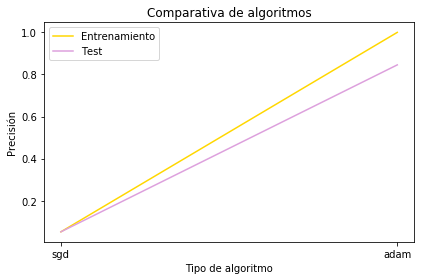

In [80]:
import matplotlib.pyplot as plt
from math import log

plt.plot(solvers, train_, label="Entrenamiento", color = "gold")
plt.plot(solvers, test_, label="Test", color = "plum")

# Create plot
plt.title("Comparativa de algoritmos")
plt.xlabel("Tipo de algoritmo"), plt.ylabel("Precisión"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [75]:
from ast import literal_eval as createTuple

data = []
functions = []
train_ = []
test_ = []

with open("functions.txt","r") as infile:
    for line in infile:
        data.append(createTuple(line))
        
for f,train,test in data:
    functions.append(f)
    train_.append(train)
    test_.append(test)

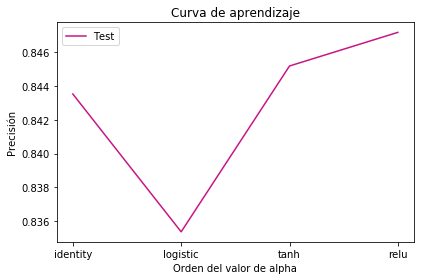

In [76]:
import matplotlib.pyplot as plt
from math import log

#plt.plot(functions, train_, label="Entrenamiento", color = "deepskyblue")
plt.plot(functions, test_, label="Test", color = "mediumvioletred")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Orden del valor de alpha"), plt.ylabel("Precisión"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [72]:
from ast import literal_eval as createTuple

data = []
alphas = []
alphas_ = []
train_ = []
test_ = []

with open("alphas.txt","r") as infile:
    for line in infile:
        data.append(createTuple(line))
        
for al,train,test in data:
    alphas_.append(al)
    train_.append(train)
    test_.append(test)
    
alphas = [log(x,10) for x in alphas_]

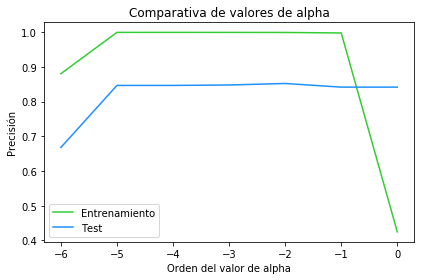

In [73]:
import matplotlib.pyplot as plt
from math import log

plt.plot(alphas, train_, label="Entrenamiento", color = "limegreen")
plt.plot(alphas, test_, label="Test", color = "dodgerblue")

# Create plot
plt.title("Comparativa de valores de alpha")
plt.xlabel("Orden del valor de alpha"), plt.ylabel("Precisión"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [55]:
from ast import literal_eval as createTuple

data = []
hls_= []
hls = []
train_ = []
test_ = []

with open("hls.txt","r") as infile:
    for line in infile:
        data.append(createTuple(line))
        
for h,train,test in data:
    hls_.append(h)
    train_.append(train)
    test_.append(test)
    
hls = [str(x) for x in hls_]

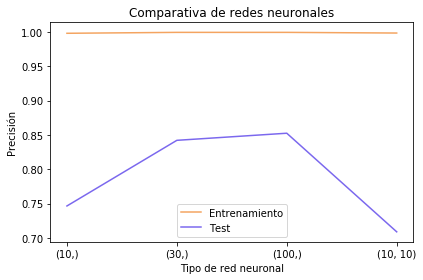

In [62]:
import matplotlib.pyplot as plt
from math import log
from matplotlib.ticker import MaxNLocator

plt.figure().gca().xaxis.set_major_locator(MaxNLocator(integer=True))


plt.plot(hls, train_, label="Entrenamiento", color = "sandybrown")
plt.plot(hls, test_, label="Test", color = "mediumslateblue")

# Create plot
plt.title("Comparativa de redes neuronales")
plt.xlabel("Tipo de red neuronal"), plt.ylabel("Precisión"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [10]:
                # Creamos el clasificador con los valores por defecto
mlp_classifier = MLPClassifier(alpha = 0.01, hidden_layer_sizes=(100,),
                                activation='relu', solver='adam',random_state=0)
mlp_classifier.fit(train_preprocessed, train_data.target)
mlp_train_predictions = mlp_classifier.predict(train_preprocessed)
mlp_test_predictions = mlp_classifier.predict(test_preprocessed)
print(time.strftime("%H:%M:%S"))
print("Parámetros = ",(np.mean(mlp_train_predictions == train_data.target),  np.mean(mlp_test_predictions == test_data.target)))
print("Perceptrón, porcentaje de aciertos en entrenamiento:", np.mean(mlp_train_predictions == train_data.target))
print("Perceptrón, porcentaje de aciertos en test:", np.mean(mlp_test_predictions == test_data.target))

17:53:26
Parámetros =  (0.9996464557185788, 0.852761550716941)
Perceptrón, porcentaje de aciertos en entrenamiento: 0.9996464557185788
Perceptrón, porcentaje de aciertos en test: 0.852761550716941


In [ ]:
mlp_classifier.n_iter_

### Otros clasificadores

Otro clasificador que se usa en PLN es la [regresión logística](https://en.wikipedia.org/wiki/Logistic_regression) (sklearn.naive_bayes.MultinomialNB) que es básicamente un modelo de regresión para variables dependientes binarias, o las más sofisticadas Máquinas de Vectores de Soporte o  [Support Vector Machines](https://en.wikipedia.org/wiki/Support_vector_machine) (`sklearn.linear_model.LogisticRegression`). 

Por último, mencionar que existen otras corrientes más actuales que usan "aprendizaje profundo" o deep learning con aún mejores resultados.

## Evaluación detallada

En un problema de clasificación multiclase suele ser muy interesante analizar dos cosas:
 - El rendimiento de la clasificación en cada una de las clases
 - La matriz de confusión

Lo primero nos permite analizar en qué clases funciona mejor o peor el clasificador, de acuerdo a métricas como la precisión (cuando predice dicha clase cuánto acierta) y la exhaustividad  (cuántos ejemplos de una clase predice correctamente). También podemos ver la media (armònica) entre ambas medidas (F1 score).

La matriz nos permite ver qué clases se confunden más entre sí y si dicha confusión es simétrica o no. 
    

### MultinomialNB (Naïve Bayes)

In [113]:
from sklearn.metrics import classification_report, confusion_matrix

# NOTA: Aquí elegimos analizar un determinado clasificador y sus predicciones 
# Por ejemplo el naive bayes
classifier=nb_classifier
predictions = nb_test_predictions

print(classification_report(test_data.target, predictions, target_names=test_data.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.85      0.85      0.85       319
           comp.graphics       0.70      0.72      0.71       389
 comp.os.ms-windows.misc       0.72      0.65      0.68       394
comp.sys.ibm.pc.hardware       0.65      0.73      0.69       392
   comp.sys.mac.hardware       0.82      0.81      0.81       385
          comp.windows.x       0.81      0.78      0.79       395
            misc.forsale       0.79      0.82      0.80       390
               rec.autos       0.88      0.89      0.88       396
         rec.motorcycles       0.93      0.95      0.94       398
      rec.sport.baseball       0.93      0.91      0.92       397
        rec.sport.hockey       0.93      0.96      0.95       399
               sci.crypt       0.88      0.92      0.90       396
         sci.electronics       0.78      0.73      0.75       393
                 sci.med       0.87      0.80      0.83       396
         

En el caso del naive Bayes hay clases que se clasifican muy bien, como `rec.sport.baseball`, `rec.sport.hockey` y `talk.politics.mideast`.

Sin embargo, es interesante que hay clases como `talk.religion.misc` con una precisión muy alta y una exhaustividad muy bajo, y por otro lado clases donde sucede lo contrario, aunque no tan acusado, como en `soc.religion.christian`.

La exhaustividad muy baja indica que esos textos tienden a confundirse mucho con otros. Una precisión baja por el contrario quiere decir que el clasificador no ha sido capaz de encontrar rasgos distintivos para dichos textos que los diferencien de otros.

Podemos echar un vistazo más a la matriz de confusión para entender mejor este problema.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <a list of 20 Text xticklabel objects>)

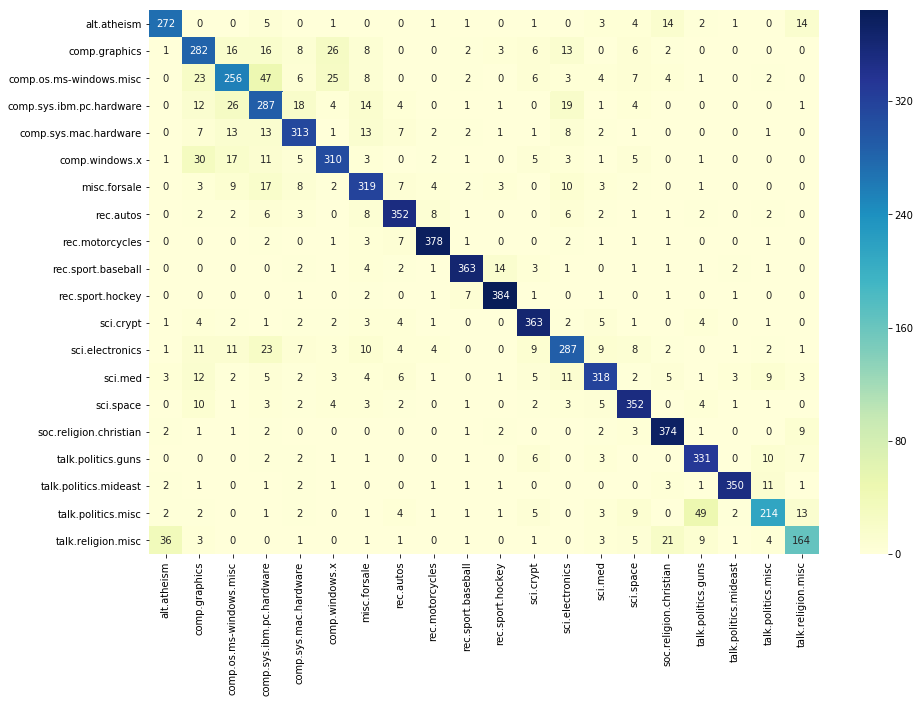

In [114]:
%matplotlib inline
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(test_data.target, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=test_data.target_names, columns=test_data.target_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Ahora podemos comprobar la fuente de las confusiones. 
- Una fila con muchas observaciones fuera de la celda de la diagonal principal, indica una exhaustividad baja. 
    - Si las observaciones se concentran en alguna celda fuera de la diagonal, indica que son clasificadas (erróneamente) como de la clase a la que pertenezca su fila. Es el caso de las observaciones de `talk.religion.misc` que son clasificadas como `soc.religion.christian`, las de `talk.politics.misc`  ques son clasificadas como `talk.politics.guns` y las de `alt.atheism` que son clasificadas como `soc.religion.christian`. Es interesante que ninguna de estas confusiones es simétrica, lo que quiere decir que, por ejemplo, los textos de `soc.religion.christian` tienen suficientes rasgos distintivos para ser diferenciados de `alt.atheism`.
- Una columna con muchas observaciones fuera de la celda de la diagonal principal, indica una una precisión baja, o una contaminación en la precisión del clasificador. 
    - Es el caso de `soc.religion.christian` o de `sci.crypt` que pese a tener una exhaustividad alta  que recupera casi todos los ejemplos (97%) tiene una precisión baja, ya que detecta como falsos positivos muchos textos de muchos otros temas.

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# NOTA: Aquí elegimos analizar un determinado clasificador y sus predicciones 
# Por ejemplo el naive bayes
classifier=mlp_classifier
predictions = mlp_test_predictions

print(classification_report(test_data.target, predictions, target_names=test_data.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.82      0.79      0.81       319
           comp.graphics       0.74      0.82      0.78       389
 comp.os.ms-windows.misc       0.77      0.76      0.77       394
comp.sys.ibm.pc.hardware       0.73      0.76      0.74       392
   comp.sys.mac.hardware       0.81      0.87      0.84       385
          comp.windows.x       0.86      0.77      0.81       395
            misc.forsale       0.84      0.90      0.87       390
               rec.autos       0.91      0.91      0.91       396
         rec.motorcycles       0.95      0.96      0.96       398
      rec.sport.baseball       0.89      0.94      0.92       397
        rec.sport.hockey       0.96      0.97      0.97       399
               sci.crypt       0.94      0.92      0.93       396
         sci.electronics       0.80      0.78      0.79       393
                 sci.med       0.91      0.84      0.88       396
         

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <a list of 20 Text xticklabel objects>)

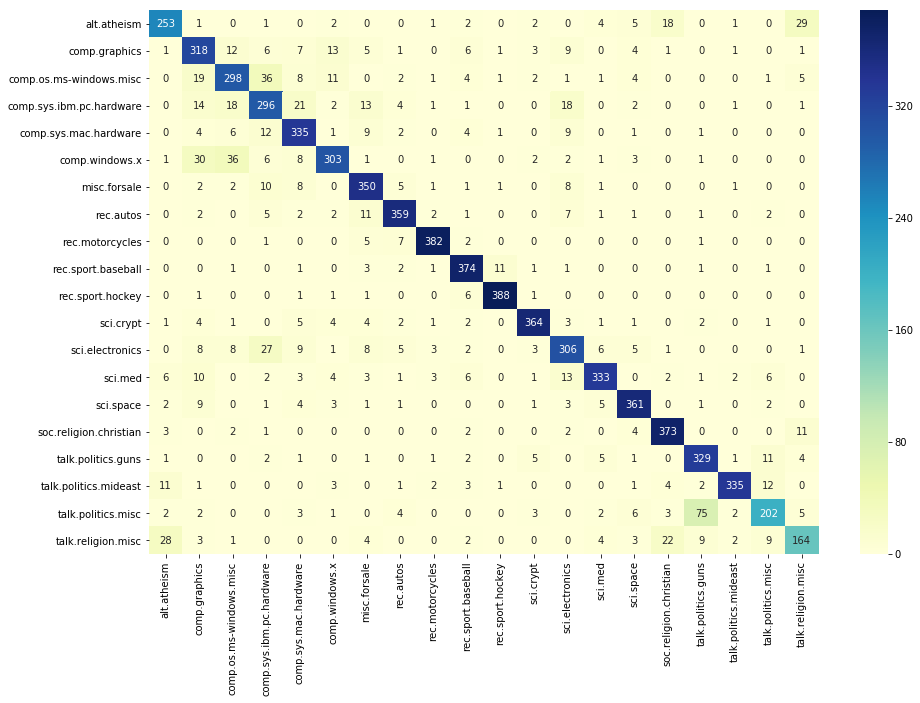

In [12]:
%matplotlib inline
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(test_data.target, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=test_data.target_names, columns=test_data.target_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

### Importancia de las variables 

Algunos algoritmos de clasificación permiten analizar cuáles son las variables más relevantes para la clasificación. Suele ser una buena idea para entender mejor los resultados analizar esas variables. En el caso de nuestro problema, lo que nos diría sería qué palabras son más útiles para realizar la clasificación. 

Este tipo de análisis es muy dependiente de la técnica que estemos utilizando, de los fundamentos en los que se base dicha técnica. De hecho, no todas las técnicas permiten hacer estos análisis ya que algunas son más "caja negra" que otras. 

Como información complementaria a lo que veremos en este notebook decir que el paquete [eli5](https://eli5.readthedocs.io/en/0.1/index.html) de Python que tiene como objetivo explicar las predicciones de algunos modelos de machine learning.

#### Árboles de decisión

En el caso de los árboles de decisión podemos obtener las variables con mayor poder de discriminación en el árbol obtenido, es decir, aquellas que mayor reducción de Gini han producido a lo largo del árbol.

In [115]:
def print_top20_features_in_trees(vectorizer, clf):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    
    top20 = np.argsort(clf.feature_importances_)[-20:]
    reversed_top = top20[::-1]
    print("Top 20 features per class\n")
    print("%s" % ( " ".join(feature_names[j] for j in reversed_top)))

print_top20_features_in_trees(vectorizer,tree_classifier)

Top 20 features per class

clipper sale dod windows hockey space israel car rutgers edu gun baseball god bike turkish mac graphics cs pitt nhl atheists window


En este caso es muy claro que estamos encontrando palabras que rápidamente nos remiten a alguno de los temas de los que tratan las noticias como es el caso de `clipper` que es un [chip de criptografía](https://www.cryptomuseum.com/crypto/usa/clipper.htm), `sale` que está asociado al grupo de compraventa `misc.forsale`, etc.

#### Naive Bayes

En el caso del Naive Bayes, por cada una de las clases a predecir, podemos obtener aquellas palabras que es más verosímil que aparezcan.  

In [119]:
def print_top20_features_per_class_in_NB(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    print("Top 20 features per class\n")
    for i, class_label in enumerate(class_labels):
        top20 = np.argsort(clf.coef_[i])[-20:]
        reversed_top = top20[::-1]
        print("%s:   %s" % (class_label,
              " ".join(feature_names[j] for j in reversed_top)))
        
print_top20_features_per_class_in_NB(vectorizer,nb_classifier,test_data.target_names)       

Top 20 features per class

alt.atheism:   keith edu god caltech edu caltech atheists livesey edu keith atheism com sgi people writes morality islam sgi com don solntze solntze wpd islamic
comp.graphics:   graphics edu image 3d files lines com university polygon subject organization thanks file program tiff posting images host nntp posting nntp
comp.os.ms-windows.misc:   windows edu file dos files driver ax ax ax drivers ms mouse com card use university win lines subject organization program
comp.sys.ibm.pc.hardware:   scsi drive ide card bus edu controller com pc isa disk drives dos thanks lines monitor subject organization vlb motherboard
comp.sys.mac.hardware:   mac apple edu drive quadra se centris simms monitor scsi duo lc lines subject problem university organization posting com nntp
comp.windows.x:   window motif mit server com edu widget mit edu xterm x11r5 application uk lcs mit lcs lines subject display program organization use
misc.forsale:   sale edu 00 offer shipping new un

Resulta interesante ver que aunque hemos usado TF-IDF para reducir el impacto de aquellas palabras más frecuentes, éstan siguen contaminando el clasificador ya que aparecen como las palabras más relevantes (por no decir frecuentes) en los textos de cada una de las categorías.

Esto quiere decir que el clasificador seguramente tiene margen de mejora si eliminamos las palabras más frecuentes de la lengua inglesa del diccionario y por tanto de nuestro clasificador.

In [17]:
def print_top20_features_per_class_in_MLP(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    print("Top 20 features per class\n")
    for i, class_label in enumerate(class_labels):
        top20 = np.argsort(clf.coefs_[i])[-20:]
        reversed_top = top20[::-1]
        print("%s:   %s" % (class_label,
              " ".join(feature_names[j] for j in reversed_top)))
        
print_top20_features_per_class_in_MLP(vectorizer,mlp_classifier,test_data.target_names)       

Top 20 features per class



TypeError: only integer scalar arrays can be converted to a scalar index

In [16]:
mlp_classifier.

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)